### 使用TDD实现FBDD方法
Quantum State Preparation via Free Binary Decision Diagram

In [32]:
import numpy as np
from MDD2.TDD import TDD, Ini_TDD,Clear_TDD,set_index_order,get_unique_table_num,get_count,cont,Slicing2,Slicing,get_index_order
from MDD2.TDD_Q import cir_2_tn,get_real_qubit_num,add_trace_line,add_inputs,add_outputs,gen_cir
from MDD2.TN import Index,Tensor,TensorNetwork
import time
import random
from qiskit import QuantumCircuit,qasm2
import cProfile
from IPython.display import display, HTML,Image
# from PIL import Image
from PIL import Image as PILImage
import networkx as nx
import copy
from qiskit.circuit.library.standard_gates import HGate,U1Gate,U3Gate
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import UnitaryGate
from Pre import Gate,Circuit,get_ref

to_test = False

In [33]:
computed_table_pre = dict()
computed_table_pre['g'] = dict() #global
computed_table_pre['b'] = dict() #borderc_control
computed_table_pre['s'] = dict() #single
computed_table_pre['m'] = dict() #multi-control
computed_table_pre['d'] = dict() #dif-branceh
computed_table_pre['r'] = dict() #merge 
computed_table_pre['n'] = dict() #non-reduce
def simulate(cir,ini=False,n=0):
    tn,all_indexs = cir_2_tn(cir)
    tn.tensors=[ts for ts in tn.tensors if ts.name!='nu_q']
    # n = get_real_qubit_num(cir)
    if n!=0:
        add_inputs(tn,[0]*n,n)
    
#     A=[ts.name for ts in tn.tensors]
#     print(A)
    if ini:
        var=[]
        for idx in all_indexs:
            if idx[0]=='x' and not '_' in idx:
                var.append('a'+idx[1:])
            var.append(idx)
            if idx[0]=='y' and not '_' in idx:
                var.append('b'+idx[1:])
#         print(var)
        for k1 in range(n):
            if not 'x'+str(k1) in var:
                var.append('x'+str(k1))
            for k in range(5*len(all_indexs)):
                s ='x'+str(k1)+'_'+str(k)
                if not s in var:
                    var.append(s)
                s ='y'+str(k1)+'_'+str(k)
                if not s in var:
                    var.append(s)               
            if not 'y'+str(k1) in var:
                var.append('y'+str(k1))
        var.reverse()
        Ini_TDD(index_order=var)
        # set_root_of_unit(2**3)
        # computed_table_pre = dict()
        # computed_table_pre['g'] = dict()
        # computed_table_pre['b'] = dict()
        # computed_table_pre['s'] = dict()
        # computed_table_pre['m'] = dict()
        # computed_table_pre['d'] = dict()
        # computed_table_pre['r'] = dict()
        # computed_table_pre['n'] = dict()
#     t_start=time.time()
    # print(var['x0'])
    A = get_index_order()
    tdd=tn.cont()
#     print(time.time()-t_start)
#     print(tdd.weight)
#     print(tdd.node_number())
    return tdd

def change_index(tdd,x,y):
    """change the index from x to y"""
    
    idx_set = []
    key_2_index  = dict()
    index_2_key = dict()
    
    for idx in tdd.index_set:
        if idx.key[0]==x:
            idx_set.append(Index(y+idx.key[1:],idx.idx))
        else:
            idx_set.append(idx)
    
    for k in tdd.key_2_index:
        if isinstance(tdd.key_2_index[k],str) and tdd.key_2_index[k][0]==x:
            key_2_index[k]=y+tdd.key_2_index[k][1:]
        else:
            key_2_index[k]=tdd.key_2_index[k]
            
    for k in tdd.index_2_key:
        if isinstance(k,str) and k[0]==x:
            index_2_key[y+k[1:]]=tdd.index_2_key[k]
        else:
            index_2_key[k]=tdd.index_2_key[k]
    tdd.index_set=idx_set
    tdd.key_2_index=key_2_index
    tdd.index_2_key = index_2_key
    
    
def update_tdd(tdd,cir_head,cir_end):
#     cir_head.x([0,1,2])
#     cir_head.x([0,1,2])
#     cir_end.x([0,1,2])
#     cir_end.x([0,1,2])
    tdd1 = simulate(cir_head)
    change_index(tdd1,'x','a')
    change_index(tdd1,'y','x')

    tdd2 = simulate(cir_end)
    change_index(tdd2,'y','b')
    change_index(tdd2,'x','y')
    
    tdd_new=cont(tdd,tdd1)
    tdd_new=cont(tdd_new,tdd2)

    change_index(tdd_new,'a','x')
    change_index(tdd_new,'b','y')
    # tdd_new=renormalize(tdd_new)
    return tdd_new

def get_downward_k_level_map(tdd,k,c):
    if k==0:
        if c==0:
            return tdd.node.out_maps[1],tdd.node.out_weight[1]
        else:
            return tdd.node.successor[0].out_maps[1],tdd.node.successor[0].out_weight[1]
    # temp_tdd = Slicing2(Slicing2(tdd,tdd.node.key,0),tdd.node.key-1,0)
    temp_tdd = Slicing2(tdd,tdd.node.key,0)
    return get_downward_k_level_map(temp_tdd,k-1,c)

In [34]:
def get_meas_prob(node):
    if node.meas_prob!=[]:
        return
    if node.key==-1:
        node.meas_prob = [0,0]
        return 
    if node.key==0:
        node.meas_prob = [node.out_weight[0],node.out_weight[1]]
        return
    if node.successor[0].meas_prob==[]:
        get_meas_prob(node.successor[0])
    if node.successor[1].meas_prob==[]:
        get_meas_prob(node.successor[1])
    skip0 = node.key-node.successor[0].key-1
    skip1 = node.key-node.successor[1].key-1
    node.meas_prob.append(node.out_weight[0]*np.sqrt((abs(node.successor[0].meas_prob[0])**2+abs(node.successor[0].meas_prob[1])**2)*2**skip0))
    node.meas_prob.append(node.out_weight[1]*np.sqrt((abs(node.successor[1].meas_prob[0])**2+abs(node.successor[1].meas_prob[1])**2)*2**skip1))
    node.successor[0].ref+=1
    node.successor[1].ref+=1

    return

def state_pre(tdd,anc_num=0):
    global S, node_qubit
    Q = [tdd.node]
    S=[]
    anc_num = tdd.node_number()-1
    n = tdd.node.key+1
    # cir = QuantumCircuit(n+anc_num)
    cir = Circuit(n+anc_num,[])
    anc_avi = n
    node_qubit = {}
    get_meas_prob(tdd.node)

    while len(Q)>0:
        u = Q.pop(0)
        S.append(u)
        if not u in node_qubit:
            node_qubit[u] = anc_avi
            anc_avi+=1

        # cir.ch(node_qubit[u],u.key)
        H =1/np.sqrt(2)*np.array([[1,1],[1,-1]])
        cir.data.append(Gate('u',{node_qubit[u]:1},u.key,H))
        
        U = np.array([[u.meas_prob[0],-np.conj(u.meas_prob[1])],[u.meas_prob[1],np.conj(u.meas_prob[0])]])
        U = 1/np.sqrt(abs(u.meas_prob[0])**2+abs(u.meas_prob[1])**2)*U
        # u3 = UnitaryGate(U)
        # cu3 = u3.control(1)
        # cir.append(cu3,[node_qubit[u],u.key])
        cir.data.append(Gate('u',{node_qubit[u]:1},u.key,U))
        
        u.successor[0].ref-=1
        if u.successor[0].ref==0 and u.successor[0].key>-1:
            Q.append(u.successor[0])
        if u.successor[0].key>-1:
            # cir.x(u.key)
            cir.data.append(Gate('x',{},u.key))
            if not u.successor[0] in node_qubit:
                node_qubit[u.successor[0]] = anc_avi
                anc_avi+=1
            # cir.ccx(u.key,node_qubit[u],node_qubit[u.successor[0]])
            cir.data.append(Gate('x',{u.key:1,node_qubit[u]:1},node_qubit[u.successor[0]]))
            # cir.x(u.key)
            cir.data.append(Gate('x',{},u.key))
            
        u.successor[1].ref-=1
        if u.successor[1].ref==0 and u.successor[1].key>-1:
            Q.append(u.successor[1])
        if u.successor[1].key>-1:
            if not u.successor[1] in node_qubit:
                node_qubit[u.successor[1]] = anc_avi
                anc_avi+=1
            # cir.ccx(u.key,node_qubit[u],node_qubit[u.successor[1]])
            cir.data.append(Gate('x',{u.key:1,node_qubit[u]:1},node_qubit[u.successor[1]]))


    for k in range(len(S)-1,-1,-1):
        u=S[k]

        if u.successor[0].key>-1:
            # cir.x(u.key)
            cir.data.append(Gate('x',{},u.key))
            # cir.ccx(u.key,node_qubit[u],node_qubit[u.successor[0]])
            cir.data.append(Gate('x',{u.key:1,node_qubit[u]:1},node_qubit[u.successor[0]]))
            # cir.x(u.key)
            cir.data.append(Gate('x',{},u.key))
            
        if u.successor[1].key>-1:
            # cir.ccx(u.key,node_qubit[u],node_qubit[u.successor[1]])
            cir.data.append(Gate('x',{u.key:1,node_qubit[u]:1},node_qubit[u.successor[1]]))

    return cir

    
def is_successful(tdd,cir_end,n):
    tn,all_indexs = cir_2_tn(cir_end)
    add_inputs(tn,['+']*n+['1']+['0']*(tdd.node_number()-2),n+tdd.node_number()-1)

    q_n = n+tdd.node_number()-1
    # print(tdd.node.key,tdd.node_number())
    var = []
    for k1 in range(q_n):
        # print(k1)
        if not 'x'+str(k1) in var:
            var.append('x'+str(k1))
        if not 'a'+str(k1) in var:
            var.append('a'+str(k1))        
        for k in range(30*q_n):
            s ='x'+str(k1)+'_'+str(k)
            if not s in var:
                var.append(s)
            s ='y'+str(k1)+'_'+str(k)
            if not s in var:
                var.append(s)               
        if not 'y'+str(k1) in var:
            var.append('y'+str(k1))
        if not 'b'+str(k1) in var:
            var.append('b'+str(k1))        
    var.reverse()
    set_index_order(var)
    tdd_new=tn.cont()
    for k in range(tdd.node_number()-2):
        tdd_new=Slicing(tdd_new,tdd_new.node.key,0)
    tdd_new=Slicing(tdd_new,tdd_new.node.key,1)        
    return tdd_new.node==tdd.node,tdd_new

{-1: -1, 0: 'y0', 1: 'y1', 2: 'y2'}


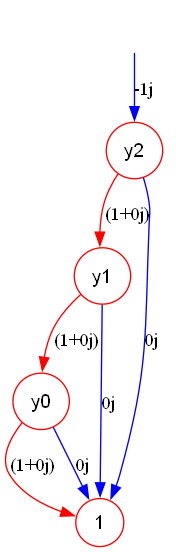

In [35]:
n=3
m=10
# cir=QuantumCircuit(1)
# cir.x(0)
cir=gen_cir('Random_Clifford_T',n,m)
tdd=simulate(cir,True,n)
print(tdd.key_2_index)
tdd.show()

True


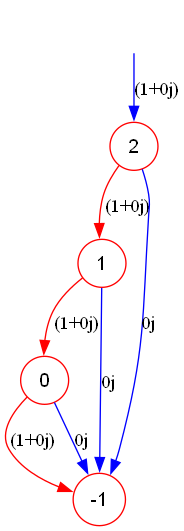

In [36]:
tdd=simulate(cir,True,n)
cir_head = QuantumCircuit(n+tdd.node_number()-1)
cir_end = state_pre(tdd.self_copy())
cir_end = cir_end.to_qis_cir()
res,tdd_new = is_successful(tdd,cir_end,n)
print(res)
tdd_new.show(False)